In [278]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re
import requests
import seaborn as sns

from db import create_connection
from db import (
    articles,
    services,
    urls
)

In [279]:
connection = create_connection()

# Get data

In [280]:
data = articles.get_articles(connection)

In [281]:
pd.set_option('max_colwidth', 100)
df = pd.DataFrame(data, columns = ['publication_date',
                                   'author',
                                   'title',
                                   'url',
                                   'koronawirus_in_text',
                                   'koronawirus_in_title'])

In [282]:
df.sample(frac = 0.0035)

,publication_date,author,title,url,koronawirus_in_text,koronawirus_in_title
671,2020-03-29 20:49:00,Paula,Kolejne zarażenia koronawirusem w woj. lubelskim! Nowe dane Ministerstwa Zdrowia,https://www.se.pl/lublin/kolejne-zarazenia-koronawirusem-nowe-dane-ministerstwa-zdrowia-aa-KC13-...,9.0,1.0
226,2020-07-13 12:57:00,Marek Targoński,Godziszów: W tej gminie KOCHAJĄ Dudę. Zdobył ponad 95 proc. głosów! [WYNIKI: Lubelskie],https://lublin.se.pl/godziszow-w-tej-gminie-kochaja-dude-zdobyl-ponad-95-proc-glosow-wyniki-lube...,0.0,0.0
1738,2020-06-05 21:41:00,MTA,Podpisy dla Rafała Trzaskowskiego. Gdzie zbierają w Lublinie? Lista miejsc [WYBORY 2020],https://www.se.pl/lublin/podpisy-dla-rafala-trzaskowskiego-gdzie-zbieraja-w-lublinie-lista-miejs...,0.0,0.0
1793,2020-05-12 18:49:00,mt,Samochód ZMIÓTŁ skuter z drogi! Nie żyje 34-letni mężczyzna. HORROR w Dąbrowie Tarnawackiej,https://www.se.pl/lublin/samochod-zmiotl-skuter-z-drogi-nie-zyje-34-letni-mezczyzna-makabra-w-da...,0.0,0.0
119,2020-07-27 08:56:00,Marek Targoński,Bezwola: PIJANA MATKA wiozła autem 7-letniego synka. Mogła spowodować KATASTROFĘ!,https://lublin.se.pl/bezwola-pijana-matka-wiozla-autem-7-letniego-synka-mogla-spowodowac-katastr...,0.0,0.0
1762,2020-05-27 11:31:00,MTA,Lubelskie: Maseczki ZNIESIONE? Jest decyzja! Kiedy i gdzie nie trzeba będzie nosić masek w Lubel...,https://www.se.pl/lublin/lubelskie-maseczki-zniesione-jest-decyzja-kiedy-i-gdzie-nie-trzeba-bedz...,15.0,0.0
143,2020-07-23 11:57:00,Mariusz Mucha,Hrebenne: Zapomniał o nabojach. Teraz czekają go kłopoty,https://lublin.se.pl/hrebenne-zapomnial-o-nabojach-teraz-czekaja-go-klopoty-aa-hLE5-eJ5A-nATC.html,0.0,0.0


# Clean data

### initial data check, organize and clearing

In [283]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 6 columns):
publication_date        1469 non-null datetime64[ns]
author                  1469 non-null object
title                   1469 non-null object
url                     2002 non-null object
koronawirus_in_text     1469 non-null float64
koronawirus_in_title    1469 non-null float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 854.2 KB


In [284]:
df.nunique()

publication_date        1459
author                   124
title                   1466
url                     2002
koronawirus_in_text       33
koronawirus_in_title       2
dtype: int64

In [285]:
df.dropna(inplace=True)
df.shape

(1469, 6)

In [286]:
df['author'] = df['author'].astype('category')
df['koronawirus_in_text'] = df['koronawirus_in_text'].astype('int')
df['koronawirus_in_title'] = df['koronawirus_in_title'].astype('int')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 2001
Data columns (total 6 columns):
publication_date        1469 non-null datetime64[ns]
author                  1469 non-null category
title                   1469 non-null object
url                     1469 non-null object
koronawirus_in_text     1469 non-null int64
koronawirus_in_title    1469 non-null int64
dtypes: category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 649.6 KB


In [287]:
df.count()

publication_date        1469
author                  1469
title                   1469
url                     1469
koronawirus_in_text     1469
koronawirus_in_title    1469
dtype: int64

### column: publication_day

In [288]:
df.insert(loc=1, column='publication_day', value=df['publication_date'].dt.strftime('%Y-%m-%d'))
df.sample(frac = 0.002)

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
422,2020-06-17 16:54:00,2020-06-17,Mucha,Chodel: W wybuch gazu stracili bliskich i dom. Potrzebna jest pomoc!,https://lublin.se.pl/chodel-w-wybuch-gazu-stracili-bliskich-i-dom-potrzebna-jest-pomoc-aa-jXuY-b...,0,0
1695,2020-06-25 17:01:00,2020-06-25,"Mucha, mta","Lublin: Zażądał pieniędzy od babci, grożąc jej granatem! Chciał ich WYSADZIĆ?! [ZDJĘCIA]",https://lublin.se.pl/lublin-zazadal-pieniedzy-od-babci-grozac-jej-granatem-a-aa-9rzB-xTNE-PLFv.html,0,0
1483,2020-08-05 10:54:00,2020-08-05,Marek Targoński,Lubelskie: 25 nowych zakażeń koronawirusem. W Tomaszowie zmarła kobieta chora na COVID-19,https://lublin.se.pl/lubelskie-25-nowych-zakazen-koronawirusem-w-tomaszowie-zmarla-kobieta-chora...,19,1


In [289]:
df.publication_day.value_counts().head()

2020-06-29    28
2020-07-08    26
2020-07-01    24
2020-07-03    22
2020-07-06    21
Name: publication_day, dtype: int64

In [290]:
df['publication_day'].nunique()

218

In [291]:
df['publication_day'] = df['publication_day'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 2001
Data columns (total 7 columns):
publication_date        1469 non-null datetime64[ns]
publication_day         1469 non-null category
author                  1469 non-null category
title                   1469 non-null object
url                     1469 non-null object
koronawirus_in_text     1469 non-null int64
koronawirus_in_title    1469 non-null int64
dtypes: category(2), datetime64[ns](1), int64(2), object(2)
memory usage: 676.7 KB


### column: publication_month

In [292]:
df.insert(loc=1, column='publication_month', value=df['publication_date'].dt.strftime('%Y-%m'))
df.sample(frac = 0.001)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
550,2020-05-12 10:11:00,2020-05,2020-05-12,AP,3 kolejne przypadki zakażenia koronawirusem w Lubelskim. NOWY RAPORT Ministerstwa Zdrowia,https://www.se.pl/lublin/3-kolejne-przypadki-zakazenia-koronawirusem-w-lubelskim-nowy-raport-min...,9,1


In [293]:
df.publication_month.value_counts().head()

2020-07    441
2020-06    211
2020-01    154
2020-05    151
2020-03    147
Name: publication_month, dtype: int64

In [294]:
df['publication_month'].nunique()

8

In [295]:
df['publication_month'] = df['publication_month'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 2001
Data columns (total 8 columns):
publication_date        1469 non-null datetime64[ns]
publication_month       1469 non-null category
publication_day         1469 non-null category
author                  1469 non-null category
title                   1469 non-null object
url                     1469 non-null object
koronawirus_in_text     1469 non-null int64
koronawirus_in_title    1469 non-null int64
dtypes: category(3), datetime64[ns](1), int64(2), object(2)
memory usage: 679.0 KB


### column: author

In [296]:
df['author'].value_counts()[:60]

mt                                 332
Mucha                              146
Marek Targoński                    132
Karolina Januszek                   88
MTA                                 78
Mariusz Mucha                       76
Mucha, mta                          54
AP                                  36
OM                                  32
KM                                  25
Bartłomiej Ważny                    22
Monika Kowalewicz                   22
AC                                  20
MK                                  16
Mateusz Kasiak                      16
Michał Michalak                     16
Agnieszka Niećko                    15
gk                                  15
Jacek Werner                        14
EIB                                 13
Sylwia Sitka-Czerniak               13
Artykuł sponsorowany                13
Olka Mazur                          13
maal                                11
Emilia Białecka                     11
RS                       

In [297]:
df['author'] = df['author'].str.lower()
regex_pattern = re.compile(r'.*mt.*', re.I)
df[df['author'].str.contains(regex_pattern)].count()

publication_date        508
publication_month       508
publication_day         508
author                  508
title                   508
url                     508
koronawirus_in_text     508
koronawirus_in_title    508
dtype: int64

In [298]:
df['author'] = df['author'].replace(['mt', 'mt; wideo: Tygodnik Zamojski'],'Marek Targoński')
df['author'] = df['author'].replace(['Mucha', 'mucha'],'Mariusz Mucha')
df['author'] = df['author'].replace(['ŁT'],'Łukasz Trybulski')
df['author'] = df['author'].replace(['Mateusz Kasiak (Radio Eska)'],'Mateusz Kasiak')
df['author'] = df['author'].replace(['KaJa'],'Karolina Januszek')
df['author'] = df['author'].replace(['RS'],'Rafał Strzelec')
df['author'] = df['author'].replace(['gk'],'Grzegorz Kluczyński')
df['author'] = df['author'].replace([''],'Nieznany')

# regex_pattern = re.compile(r'(.*,.*|.*/.*|Redakcja ESKA INFO|Nieznany|Akcja partnerska)', re.I)
# df['author'] = df['author'].replace(regex_pattern,'Więcej autorów lub nieznany')

regex_pattern = re.compile(r'.*mt.*', re.I)
df['author'] = df['author'].replace(regex_pattern,'Marek Targoński')

df['author'].value_counts()[:50]

Marek Targoński                        508
Mariusz Mucha                          147
marek targoński                        132
karolina januszek                       88
mariusz mucha                           76
ap                                      36
om                                      32
km                                      25
bartłomiej ważny                        22
monika kowalewicz                       22
ac                                      20
maal                                    17
michał michalak                         16
mk                                      16
mateusz kasiak                          16
Grzegorz Kluczyński                     15
agnieszka niećko                        15
jacek werner                            14
olka mazur                              13
eib                                     13
sylwia sitka-czerniak                   13
artykuł sponsorowany                    13
emilia białecka                         11
rs         

In [299]:
df['author'] = df['author'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 2001
Data columns (total 8 columns):
publication_date        1469 non-null datetime64[ns]
publication_month       1469 non-null category
publication_day         1469 non-null category
author                  1469 non-null category
title                   1469 non-null object
url                     1469 non-null object
koronawirus_in_text     1469 non-null int64
koronawirus_in_title    1469 non-null int64
dtypes: category(3), datetime64[ns](1), int64(2), object(2)
memory usage: 673.9 KB


### column: koronawiorus_text

In [300]:
df.loc[[919, 1979, 1965], 'koronawirus_in_text'] = 0

### column: koronawiorus_anywhere

In [301]:
df['koronawirus_anywhere'] = 0
df['koronawirus_anywhere'] = df['koronawirus_in_text'] + df['koronawirus_in_title']
# df.loc[df.koronawirus_anywhere > 0, 'koronawirus_anywhere'] = 1
df.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
0,2020-08-15 09:10:00,2020-08,2020-08-15,marek targoński,Lubelskie: Ponad 360 aktywnych przypadków COVID-19. Już 21 ognisk epidemii koronawirusa,https://lublin.se.pl/lubelskie-ponad-360-aktywnych-przypadkow-covid-19-juz-21-ognisk-epidemii-ko...,14,1,15


# Project

### Łączna ilość artykułów

In [302]:
df.shape[0]

1469

### Dni z  największą liczbą opublikowanych artykułów

In [303]:
df.publication_day.value_counts().head(3)

2020-06-29    28
2020-07-08    26
2020-07-01    24
Name: publication_day, dtype: int64

### Ilość opublikowanych artykułów w każdym miesiącu

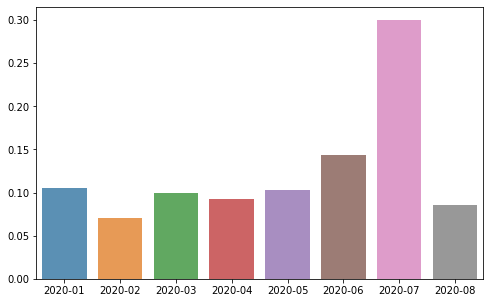

In [304]:
publication_month_count = df.publication_month.value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_count.index, publication_month_count.values, alpha=0.8)
plt.show()

IndexError: tuple index out of range

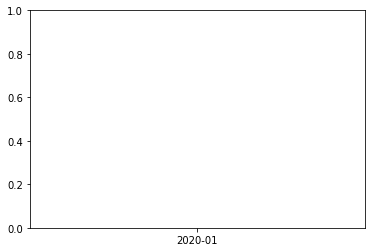

In [305]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()

plt.plot(df.groupby('publication_month').count())
plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count())
plt.plot(df_with_koronawirus_in_text.groupby('publication_month').count())
plt.show()

### Pierwsze opublikowane artykuły o covid

In [ ]:
covid_articles = df.sort_values(by=['koronawirus_in_title', 'publication_date'], ascending=[False, True])
covid_articles[['publication_date', 'author', 'title', 'url']].head(8)

### łączna ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [306]:
# df.koronawirus_in_title.sum()

df.groupby('koronawirus_in_title').count()

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_anywhere
koronawirus_in_title,,,,,,,,
0,1134,1134,1134,1134,1134,1134,1134,1134
1,335,335,335,335,335,335,335,335


### średnia ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [307]:
df.koronawirus_in_title.mean()

0.22804628999319265

### Ilość opublikowanych artykułów ze słowem "k" w tytule w każdym miesiącu + porównanie

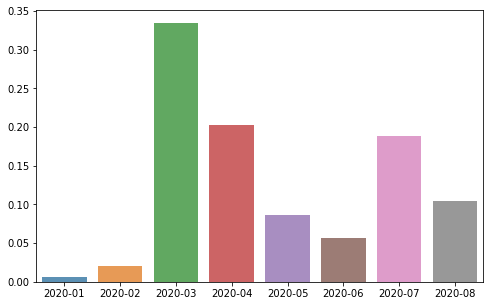

In [308]:
publication_month_with_koronawirus_in_title_count = df_with_koronawirus_in_title.publication_month.value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_title_count.index, publication_month_with_koronawirus_in_title_count.values, alpha=0.8)
plt.show()

IndexError: tuple index out of range

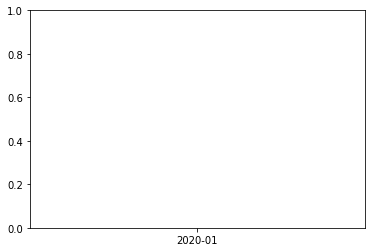

In [309]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()

plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
         color='g',
        marker='*')
plt.ylabel("liczba artykułów")
plt.legend(["koronawirus w tytule"])
plt.show()

### Łączna ilość artykułów mających w tekście słowo z grupy "koronawirus"

In [310]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df['koronawirus_in_text'][koronawirus_in_text_true].count()

533

In [311]:
koronawirus_in_text_true.mean()

0.36283185840707965

### Ilość opublikowanych artykułów ze słowem "k" w tekście w każdym miesiącu

In [312]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
0,2020-08-15 09:10:00,2020-08,2020-08-15,marek targoński,Lubelskie: Ponad 360 aktywnych przypadków COVID-19. Już 21 ognisk epidemii koronawirusa,https://lublin.se.pl/lubelskie-ponad-360-aktywnych-przypadkow-covid-19-juz-21-ognisk-epidemii-ko...,14.0,1.0,15.0


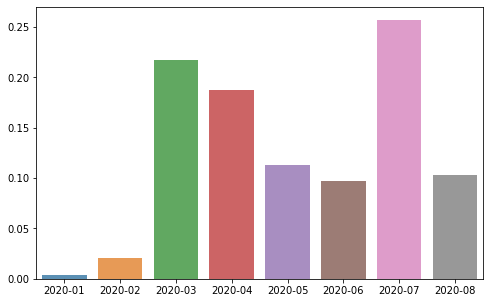

In [313]:
publication_month_with_koronawirus_in_text_count = df_with_koronawirus_in_text.publication_month.value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_text_count.index, publication_month_with_koronawirus_in_text_count.values, alpha=0.8)
plt.show()

IndexError: tuple index out of range

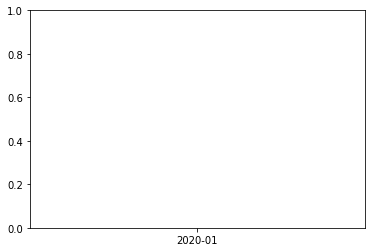

In [314]:

a = plt.plot(df_with_koronawirus_in_text.groupby('publication_month').count(),
        color='r',
        marker='.')

b = plt.plot(df_with_koronawirus_in_title.groupby('publication_month').count(),
        color='g',
        marker='*',
            label='b')

plt.ylabel("liczba artykułów")

plt.legend(a, ["koronawirus w tekście"])
plt.show()

In [315]:
df_with_koronawirus_in_text.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
publication_month,,,,,,,,
2020-01,2,2,2,2,2,2,2,2
2020-02,11,11,11,11,11,11,11,11
2020-03,116,116,116,116,116,116,116,116
2020-04,100,100,100,100,100,100,100,100
2020-05,60,60,60,60,60,60,60,60
2020-06,52,52,52,52,52,52,52,52
2020-07,137,137,137,137,137,137,137,137
2020-08,55,55,55,55,55,55,55,55


In [316]:
df_with_koronawirus_in_title.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
publication_month,,,,,,,,
2020-01,2,2,2,2,2,2,2,2
2020-02,7,7,7,7,7,7,7,7
2020-03,112,112,112,112,112,112,112,112
2020-04,68,68,68,68,68,68,68,68
2020-05,29,29,29,29,29,29,29,29
2020-06,19,19,19,19,19,19,19,19
2020-07,63,63,63,63,63,63,63,63
2020-08,35,35,35,35,35,35,35,35


### łączna ilość słów z grupy "koronawirus"

In [317]:
df.koronawirus_in_text.sum()

5790

### średnia ilość słów z grupy "koronawirus" biorąc pod uwagę tematyczne

In [318]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df['koronawirus_in_text'][koronawirus_in_text_true].mean()

10.863039399624766

### Artykuł z największą ilością słów z serii "covid"

In [319]:
# df.loc[df.koronawirus_in_text.idxmax()]

# df['koronawirus_in_text_rank'] = df['koronawirus_in_text'].rank(ascending=False)
# df.sort_values(by='koronawirus_in_text', ascending=False).head(15)

# df.sort_values(by='koronawirus_in_text', ascending=False)[:5]

df.nlargest(n=5, columns='koronawirus_in_text')

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
1833,2020-04-16 22:42:00,2020-04,2020-04-16,paweł tabędzki / marek targoński / sylwia sitka-czerniak / konrad marzec,Przełom w walce z koronawirusem?! ARCYWAŻNE zmiany ogłoszone przez rząd. Koronawirus w Polsce [Z...,https://www.se.pl/lublin/liczba-zgonow-i-zakazonych-rosnie-najnowsze-informacje-oraz-statystyki-...,500,1,501
1851,2020-04-07 07:00:00,2020-04,2020-04-07,"magdalena jaśkiewicz-stawowczyk, marek targoński",Szokujący bilans koronawirusa w Polsce. Ważne słowa prezydenta Dudy. Groza w UK [ZAPIS RELACJI N...,https://www.se.pl/lublin/koronawirus-w-polsce-dzis-niedziela-palmowa-pierwsza-taka-w-historii-ko...,461,1,462
747,2020-03-04 22:25:00,2020-03,2020-03-04,Marek Targoński,Koronawirus w Polsce! Oto konsekwencje: wzrost cen i wysoki popyt [ZAPIS RELACJI NA ŻYWO],https://www.se.pl/lublin/koronawirus-w-polsce-tytul-relacja-na-zywo-aa-jzM9-R6pH-GAfM.html,313,1,314
709,2020-03-19 09:22:00,2020-03,2020-03-19,Marek Targoński,Koronawirus Lubelskie: COVID-19 na Lubelszczyźnie. Kto i gdzie choruje? Kim są pacjenci?,https://www.se.pl/lublin/koronawirus-lubelskie-covid-19-na-lubelszczyznie-kto-i-gdzie-choruje-ki...,43,1,44
806,2020-02-08 22:25:00,2020-02,2020-02-08,Marek Targoński,KORONAWIRUS w Lublinie? Znamy wyniki badań! NOWE INFORMACJE [RELACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-pacjent-trafil-do-szpitala-trwaja-badania-audio-...,29,1,30


### Ilość słów z grupy "koronaworus" w każdym miesiącu

IndexError: tuple index out of range

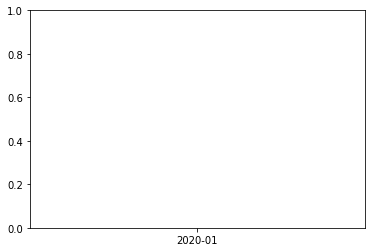

In [320]:
df_with_koronawirus_in_text = df[["koronawirus_in_text", 'publication_month']].where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text
plt.plot(
    df_with_koronawirus_in_text.groupby('publication_month').sum(),
    color="r",
    label='gggggggg'
)
plt.legend()

### Autor najwiekszej ilości artykułów ze słowem z grupy "koronawirus" w tytule

In [321]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
df_with_koronawirus_in_title['author'].value_counts()[:1]

Marek Targoński    159
Name: author, dtype: int64

### Autor najwiekszej ilości artykułów ze słowem z grupy "koronawirus" w tekście

In [322]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text['author'].value_counts()[:1]


Marek Targoński    215
Name: author, dtype: int64

IndexError: tuple index out of range

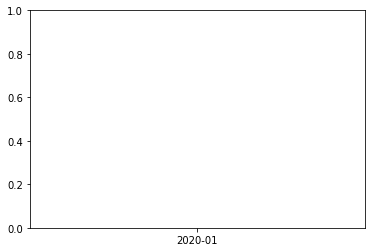

In [323]:
plt.plot(df.query('author == "Marek Targoński"').groupby('publication_month').sum())

In [ ]:
mt = df[df['author'].isin(['Marek Targoński'])]
del mt['koronawirus_in_title']
del mt['koronawirus_in_text']
mt.groupby('publication_month').sum()

In [324]:
type(mt)

pandas.core.frame.DataFrame

In [325]:
df.groupby('publication_month').count()

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
publication_month,,,,,,,,
2020-01,154,154,154,154,154,154,154,154
2020-02,104,104,104,104,104,104,104,104
2020-03,147,147,147,147,147,147,147,147
2020-04,136,136,136,136,136,136,136,136
2020-05,151,151,151,151,151,151,151,151
2020-06,211,211,211,211,211,211,211,211
2020-07,441,441,441,441,441,441,441,441
2020-08,125,125,125,125,125,125,125,125


In [326]:
# df[koronawirus_in_title_true & ~ koronawirus_in_text_true].head()

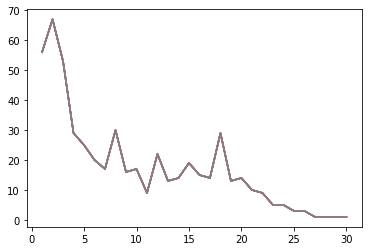

In [327]:
koronawirus_anywhere_true = df['koronawirus_anywhere'] > 0
koronawirus_anywhere_true_count = df.where(koronawirus_anywhere_true).groupby('koronawirus_anywhere').count()[:31]
plt.plot(koronawirus_anywhere_true_count)

In [328]:
koronawirus_anywhere_true_count.sort_values(by='url', ascending=False)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
koronawirus_anywhere,,,,,,,,
2.0,67,67,67,67,67,67,67,67
1.0,56,56,56,56,56,56,56,56
3.0,53,53,53,53,53,53,53,53
8.0,30,30,30,30,30,30,30,30
4.0,29,29,29,29,29,29,29,29
18.0,29,29,29,29,29,29,29,29
5.0,25,25,25,25,25,25,25,25
12.0,22,22,22,22,22,22,22,22
6.0,20,20,20,20,20,20,20,20


In [329]:
title_false = df['koronawirus_in_title'] == 0
text_true = df['koronawirus_in_text'] > 0
publication_month_07 = df['publication_month'] == "2020-07"

df_title_false_and_text_true = df[title_false & text_true & publication_month_07]

df_title_false_and_text_true.sort_values(by='koronawirus_in_text', ascending=False)[:50]

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
102,2020-07-28 17:28:00,2020-07,2020-07-28,karolina januszek,Zakaz handlu tymczasowo zniesiony? Jest projekt,https://lublin.se.pl/zakaz-handlu-tymczasowo-zniesiony-jest-projekt-ak-UDmc-xk46-WKyr.html,12,0,12
247,2020-07-10 10:01:00,2020-07,2020-07-10,maal,Fundacja Poczty Polskiej pomaga nie tylko pocztowcom,https://lublin.se.pl/fundacja-poczty-polskiej-pomaga-nie-tylko-pocztowcom-ak-mhyB-eDys-5KSt.html,10,0,10
253,2020-07-09 18:24:00,2020-07,2020-07-09,maal,Obowiązkowe mierzenie temperatury pracownikom w Polsce! Ministerstwo reaguje,https://lublin.se.pl/obowiazkowe-mierzenie-temperatury-pracownikom-w-polsce-ministerstwo-reaguje...,9,0,9
132,2020-07-24 17:07:00,2020-07,2020-07-24,kaja,Żabka przekazała 3 mln złotych polskim szpitalom. Wszystko dzięki klientom sieci,https://lublin.se.pl/zabka-przekazala-3-mln-zlotych-polskim-szpitalom-wszystko-dzieki-klientom-s...,8,0,8
1651,2020-07-03 14:20:00,2020-07,2020-07-03,karolina januszek,Primark w Polsce. Co dalej z otwarciem sklepu w Warszawie?,https://lublin.se.pl/primark-w-polsce-co-dalej-z-otwarciem-sklepu-w-warszawie-ak-7vbs-ADkt-xaho....,5,0,5
156,2020-07-22 12:13:00,2020-07,2020-07-22,karolina januszek,Minister Finansów o deficycie. Padła gigantyczna kwota,https://lublin.se.pl/minister-finansow-o-deficycie-padla-gigantyczna-kwota-ak-BwaP-W8ob-8aQ8.html,5,0,5
175,2020-07-20 13:30:00,2020-07,2020-07-20,karolina januszek,Koniec pracy zdalnej. Jak przygotować firmę na powrót pracowników?,https://lublin.se.pl/koniec-pracy-zdalnej-jak-przygotowac-firme-na-powrot-pracownikow-ak-ftj7-XG...,4,0,4
316,2020-07-03 15:34:00,2020-07,2020-07-03,om,Studenci z Lublina zaprojektowali wyjątkowy bolid i wygrali konkurs dla konstruktorów [WIDEO],https://lublin.se.pl/studenci-z-lublina-zaprojektowali-wyjatkowy-bolid-i-wygrali-konkurs-dla-kon...,4,0,4
1586,2020-07-14 12:50:00,2020-07,2020-07-14,bartłomiej ważny,"Nadwaga, cukrycza i inne schorzenia - sprawdź, co grozi Twojemu dziecku [AUDIO]",https://lublin.se.pl/nadwaga-cukrycza-i-inne-schorzenia-sprawdz-co-grozi-twojemu-dziecku-audio-a...,4,0,4
1576,2020-07-15 14:13:00,2020-07,2020-07-15,sylwia sitka-czerniak,"Matura 2020: Kiedy będą wyniki matur 2020 [WYNIKI MATURA 2020, CKE, OKE]",https://lublin.se.pl/matura-2020-kiedy-beda-wyniki-matur-2020-wyniki-matura-2020-cke-ak-7VZL-nb2...,4,0,4


In [330]:
df

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title,koronawirus_anywhere
0,2020-08-15 09:10:00,2020-08,2020-08-15,marek targoński,Lubelskie: Ponad 360 aktywnych przypadków COVID-19. Już 21 ognisk epidemii koronawirusa,https://lublin.se.pl/lubelskie-ponad-360-aktywnych-przypadkow-covid-19-juz-21-ognisk-epidemii-ko...,14,1,15
1,2020-08-14 14:02:00,2020-08,2020-08-14,tom,"Kim jest Tomasz Zalewa? Rozrzucał śmieci w centrum Lublina. To nie jedyny ""wyskok""",https://lublin.se.pl/kim-jest-tomasz-zalewa-rozrzucal-smieci-w-centrum-lublina-to-nie-jedyne-wyc...,0,0,0
2,2020-08-14 10:49:00,2020-08,2020-08-14,marek targoński,Lubelskie: 23 NOWE PRZYPADKI koronawirusa. W całym kraju ponad 800 [NOWE DANE],https://lublin.se.pl/lubelskie-23-nowe-przypadki-koronawirusa-w-calym-kraju-ponad-800-nowe-dane-...,15,1,16
3,2020-08-14 09:27:00,2020-08,2020-08-14,marek targoński,Koronawirus. Lubelskie: 380 aktywnych przypadków COVID-19. W tych powiatach [MAPA],https://lublin.se.pl/koronawirus-lubelskie-380-aktywnych-przypadkow-covid-19-w-tych-powiatach-ma...,18,1,19
4,2020-08-14 07:01:00,2020-08,2020-08-14,kaja,"Polacy zaciskają pasa, a Rzecznik Finansowy chce prywatną toaletę",https://lublin.se.pl/polacy-zaciskaja-pasa-a-rzecznik-finansowy-chce-prywatna-toalete-ak-M99T-c5...,2,0,2
...,...,...,...,...,...,...,...,...,...
1997,2020-01-04 11:13:00,2020-01,2020-01-04,michał michalak,Jedyny sposób na segregowanie śmieci? Wymyśliła to spółdzielnia w Białej Podlaskiej!,https://www.se.pl/lublin/jedyny-sposob-na-segregowanie-smieci-wymyslila-to-spoldzielnia-w-bialej...,0,0,0
1998,2020-01-03 11:45:00,2020-01,2020-01-03,agnieszka niećko,Lublin: Na autobus poczekamy dłużej. Zarząd Transportu Miejskiego zapowiada zmiany,https://www.se.pl/lublin/na-autobus-poczekamy-dluzej-w-lublinie-zarzad-transportu-miejskiego-zap...,0,0,0
1999,2020-01-02 21:15:00,2020-01,2020-01-02,Mariusz Mucha,"Zatłukli sąsiada, a sąd był łaskawy",https://www.se.pl/lublin/i-to-ma-byc-sprawiedliwosc-zatlukli-sasiada-a-sad-byl-laskawy-aa-phGN-Y...,0,0,0
2000,2020-01-02 13:33:00,2020-01,2020-01-02,om,"Lubelskie: Sylwester i Nowy Rok spokojne, ale służby interweniowały wiele razy [AUDIO]",https://www.se.pl/lublin/lubelskie-sylwester-i-nowy-rok-spokojne-ale-sluzby-interweniowaly-wiele...,0,0,0


In [348]:
df.pivot_table(index='koronawirus_in_title', columns='publication_month', values='koronawirus_anywhere', aggfunc=[min, max])

min                                                  \
publication_month    2020-01 2020-02 2020-03 2020-04 2020-05 2020-06 2020-07   
koronawirus_in_title                                                           
0                          0       0       0       0       0       0       0   
1                          8       4       1       2       4       3       2   

                                 max                                          \
publication_month    2020-08 2020-01 2020-02 2020-03 2020-04 2020-05 2020-06   
koronawirus_in_title                                                           
0                          0       0       5       6      16      15       9   
1                          3      16      30     314     501      25      24   

                                      
publication_month    2020-07 2020-08  
koronawirus_in_title                  
0                         12       5  
1                         27      26